In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 26.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-q5f6_qhw
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-q5f6_qhw
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit 12f6dcb786f5de9c5cc9a85f32df34a7958b0a04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
import tqdm
import copy
from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter


from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
#from torch_geometric.explain import Explainer, GNNExplainer
import torch_geometric.nn as gnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
Explainability_name = 'GlobalConceptBased'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"
DataSet_name = "MUTAG"

File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [7]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [8]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
print(train_dataloader.batch_size)
batch = next(iter(train_dataloader))
print(batch.y)
print(len(train_dataloader))

64
tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
3


In [10]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
GNN_Model = Graph_Network.GCN_plus_GAP(model_name=Model_name, model_level='graph', input_dim=7, hidden_dim=64, output_dim=2,
                                       num_hid_layers=2, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
                                       dropout_rate=classifier_dropout)
#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 64
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
ReLu is Selected.


In [11]:
print(GNN_Model)

GCN_plus_GAP(
  (GConvs): ModuleList(
    (0): GCNConv(7, 64)
    (1): GCNConv(64, 64)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=64, out_features=2, bias=True)
)


In [12]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [13]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [14]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [15]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        batch_loss = loss_calculations(soft, batch_of_graphs.y)
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
        #print('passed')
        Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [16]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
          torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.6879
Epoch: 002, Model Loss: 0.6847
Epoch: 003, Model Loss: 0.6748
Epoch: 004, Model Loss: 0.6727
Epoch: 005, Model Loss: 0.6649
Epoch: 006, Model Loss: 0.6660
Epoch: 007, Model Loss: 0.6522
Epoch: 008, Model Loss: 0.6455
Epoch: 009, Model Loss: 0.6526
Epoch: 010, Model Loss: 0.6423
Epoch: 011, Model Loss: 0.6338
Epoch: 012, Model Loss: 0.6381
Epoch: 013, Model Loss: 0.6206
Epoch: 014, Model Loss: 0.6352
Epoch: 015, Model Loss: 0.6290
Epoch: 016, Model Loss: 0.6313
Epoch: 017, Model Loss: 0.6114
Epoch: 018, Model Loss: 0.6232
Epoch: 019, Model Loss: 0.6231
Epoch: 020, Model Loss: 0.6309
Epoch: 021, Model Loss: 0.6010
Epoch: 022, Model Loss: 0.6113
Epoch: 023, Model Loss: 0.6166
Epoch: 024, Model Loss: 0.6278
Epoch: 025, Model Loss: 0.6016
Epoch: 026, Model Loss: 0.6158
Epoch: 027, Model Loss: 0.6147
Epoch: 028, Model Loss: 0.6164
Epoch: 029, Model Loss: 0.6025
Epoch: 030, Model Loss: 0.6144
Epoch: 031, Model Loss: 0.6081
Epoch: 032, Model Loss: 0.6109
Epoch: 0

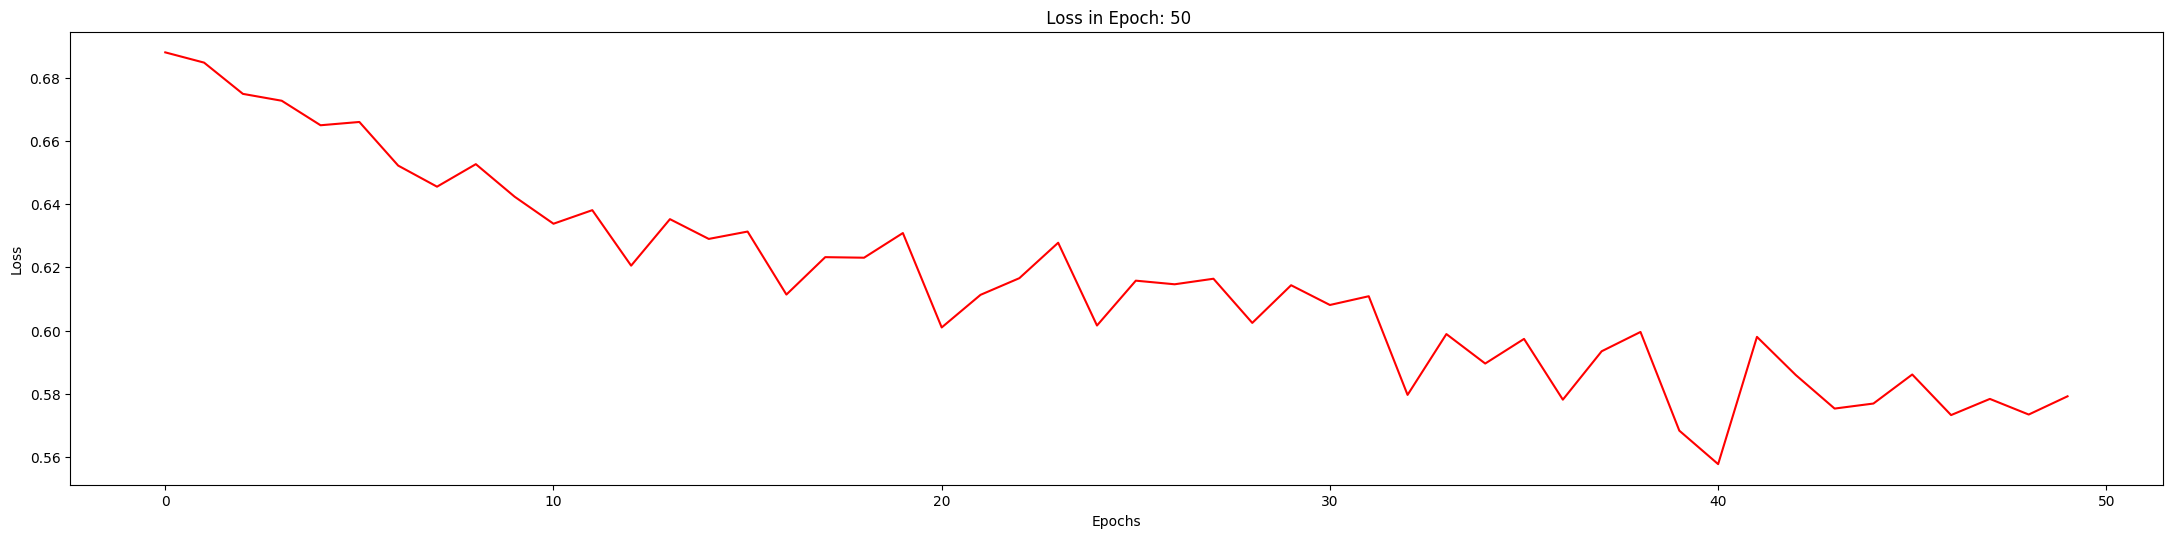

Epoch: 051, Model Loss: 0.5531
Epoch: 052, Model Loss: 0.5660
Epoch: 053, Model Loss: 0.5854
Epoch: 054, Model Loss: 0.5484
Epoch: 055, Model Loss: 0.5702
Epoch: 056, Model Loss: 0.5493
Epoch: 057, Model Loss: 0.5762
Epoch: 058, Model Loss: 0.5672
Epoch: 059, Model Loss: 0.5708
Epoch: 060, Model Loss: 0.5552
Epoch: 061, Model Loss: 0.5611
Epoch: 062, Model Loss: 0.5707
Epoch: 063, Model Loss: 0.5623
Epoch: 064, Model Loss: 0.5600
Epoch: 065, Model Loss: 0.5667
Epoch: 066, Model Loss: 0.5676
Epoch: 067, Model Loss: 0.5650
Epoch: 068, Model Loss: 0.5598
Epoch: 069, Model Loss: 0.5358
Epoch: 070, Model Loss: 0.5667
Epoch: 071, Model Loss: 0.5642
Epoch: 072, Model Loss: 0.5558
Epoch: 073, Model Loss: 0.5432
Epoch: 074, Model Loss: 0.5789
Epoch: 075, Model Loss: 0.5742
Epoch: 076, Model Loss: 0.5712
Epoch: 077, Model Loss: 0.5546
Epoch: 078, Model Loss: 0.5576
Epoch: 079, Model Loss: 0.5520
Epoch: 080, Model Loss: 0.5621
Epoch: 081, Model Loss: 0.5687
Epoch: 082, Model Loss: 0.5606
Epoch: 0

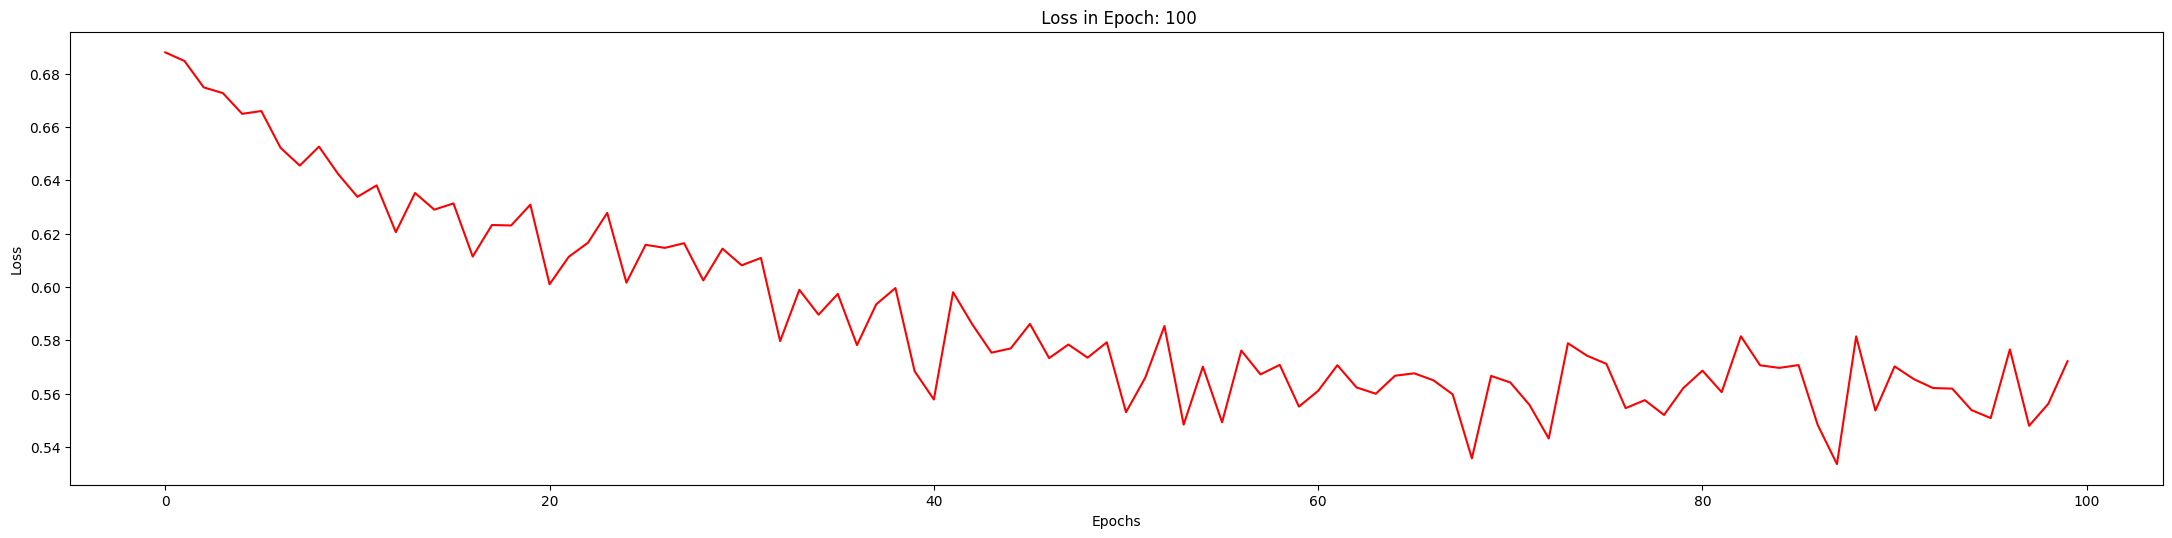

Epoch: 101, Model Loss: 0.5529
Epoch: 102, Model Loss: 0.5558
Epoch: 103, Model Loss: 0.5445
Epoch: 104, Model Loss: 0.5566
Epoch: 105, Model Loss: 0.5681
Epoch: 106, Model Loss: 0.5520
Epoch: 107, Model Loss: 0.5620
Epoch: 108, Model Loss: 0.5771
Epoch: 109, Model Loss: 0.5428
Epoch: 110, Model Loss: 0.5607
Epoch: 111, Model Loss: 0.5531
Epoch: 112, Model Loss: 0.5663
Epoch: 113, Model Loss: 0.5615
Epoch: 114, Model Loss: 0.5582
Epoch: 115, Model Loss: 0.5497
Epoch: 116, Model Loss: 0.5571
Epoch: 117, Model Loss: 0.5498
Epoch: 118, Model Loss: 0.5397
Epoch: 119, Model Loss: 0.5643
Epoch: 120, Model Loss: 0.5522
Epoch: 121, Model Loss: 0.5401
Epoch: 122, Model Loss: 0.5554
Epoch: 123, Model Loss: 0.5516
Epoch: 124, Model Loss: 0.5525
Epoch: 125, Model Loss: 0.5494
Epoch: 126, Model Loss: 0.5669
Epoch: 127, Model Loss: 0.5520
Epoch: 128, Model Loss: 0.5325
Epoch: 129, Model Loss: 0.5503
Epoch: 130, Model Loss: 0.5511
Epoch: 131, Model Loss: 0.5543
Epoch: 132, Model Loss: 0.5329
Epoch: 1

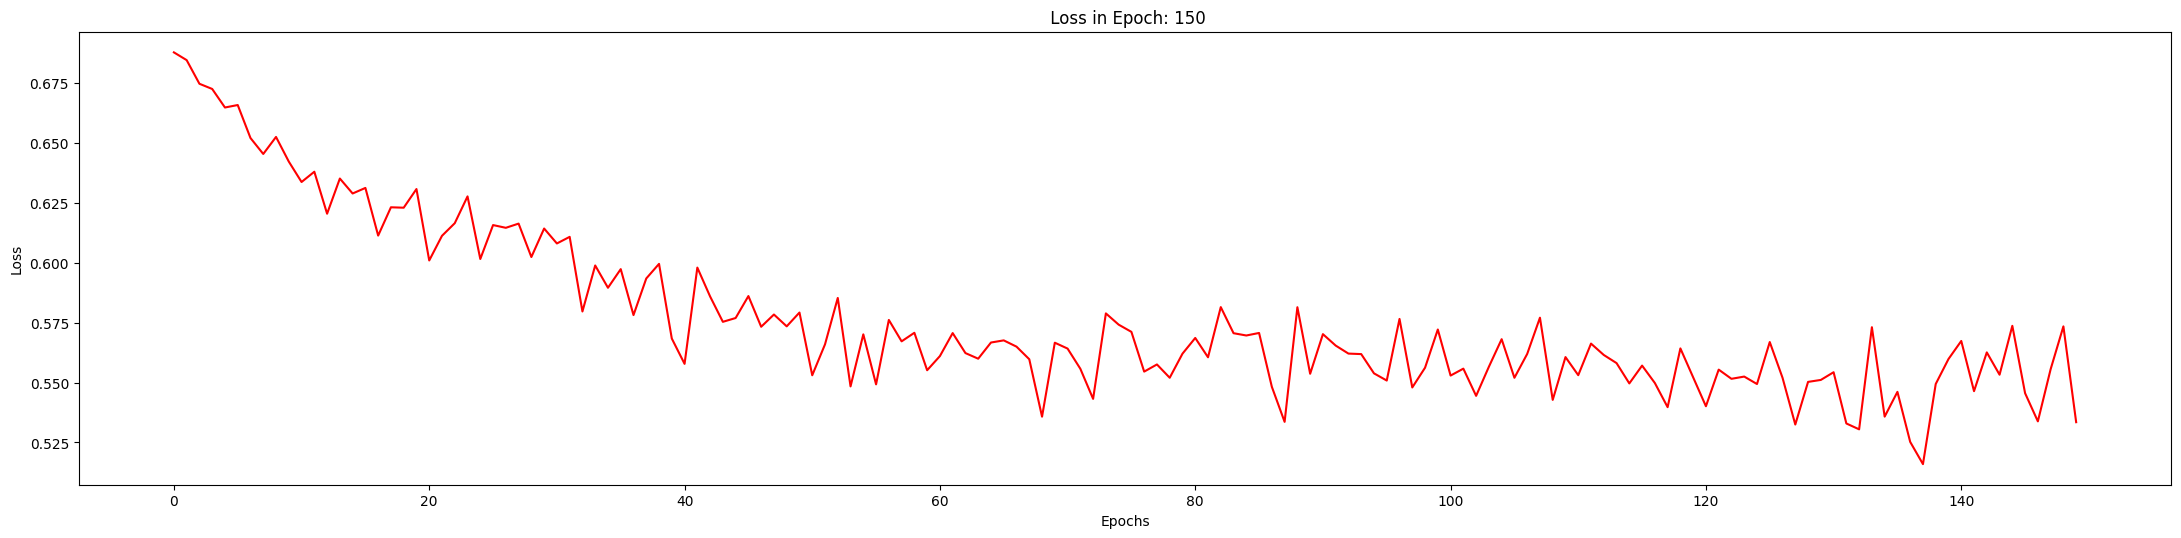

Epoch: 151, Model Loss: 0.5488
Epoch: 152, Model Loss: 0.5552
Epoch: 153, Model Loss: 0.5335
Epoch: 154, Model Loss: 0.5615
Epoch: 155, Model Loss: 0.5360
Epoch: 156, Model Loss: 0.5560
Epoch: 157, Model Loss: 0.5349
Epoch: 158, Model Loss: 0.5431
Epoch: 159, Model Loss: 0.5275
Epoch: 160, Model Loss: 0.5425
Epoch: 161, Model Loss: 0.5388
Epoch: 162, Model Loss: 0.5545
Epoch: 163, Model Loss: 0.5316
Epoch: 164, Model Loss: 0.5323
Epoch: 165, Model Loss: 0.5372
Epoch: 166, Model Loss: 0.5274
Epoch: 167, Model Loss: 0.5215
Epoch: 168, Model Loss: 0.5318
Epoch: 169, Model Loss: 0.5445
Epoch: 170, Model Loss: 0.5400
Epoch: 171, Model Loss: 0.5412
Epoch: 172, Model Loss: 0.5384
Epoch: 173, Model Loss: 0.5685
Epoch: 174, Model Loss: 0.5340
Epoch: 175, Model Loss: 0.5354
Epoch: 176, Model Loss: 0.5599
Epoch: 177, Model Loss: 0.5313
Epoch: 178, Model Loss: 0.5407
Epoch: 179, Model Loss: 0.5491
Epoch: 180, Model Loss: 0.5587
Epoch: 181, Model Loss: 0.5663
Epoch: 182, Model Loss: 0.5370
Epoch: 1

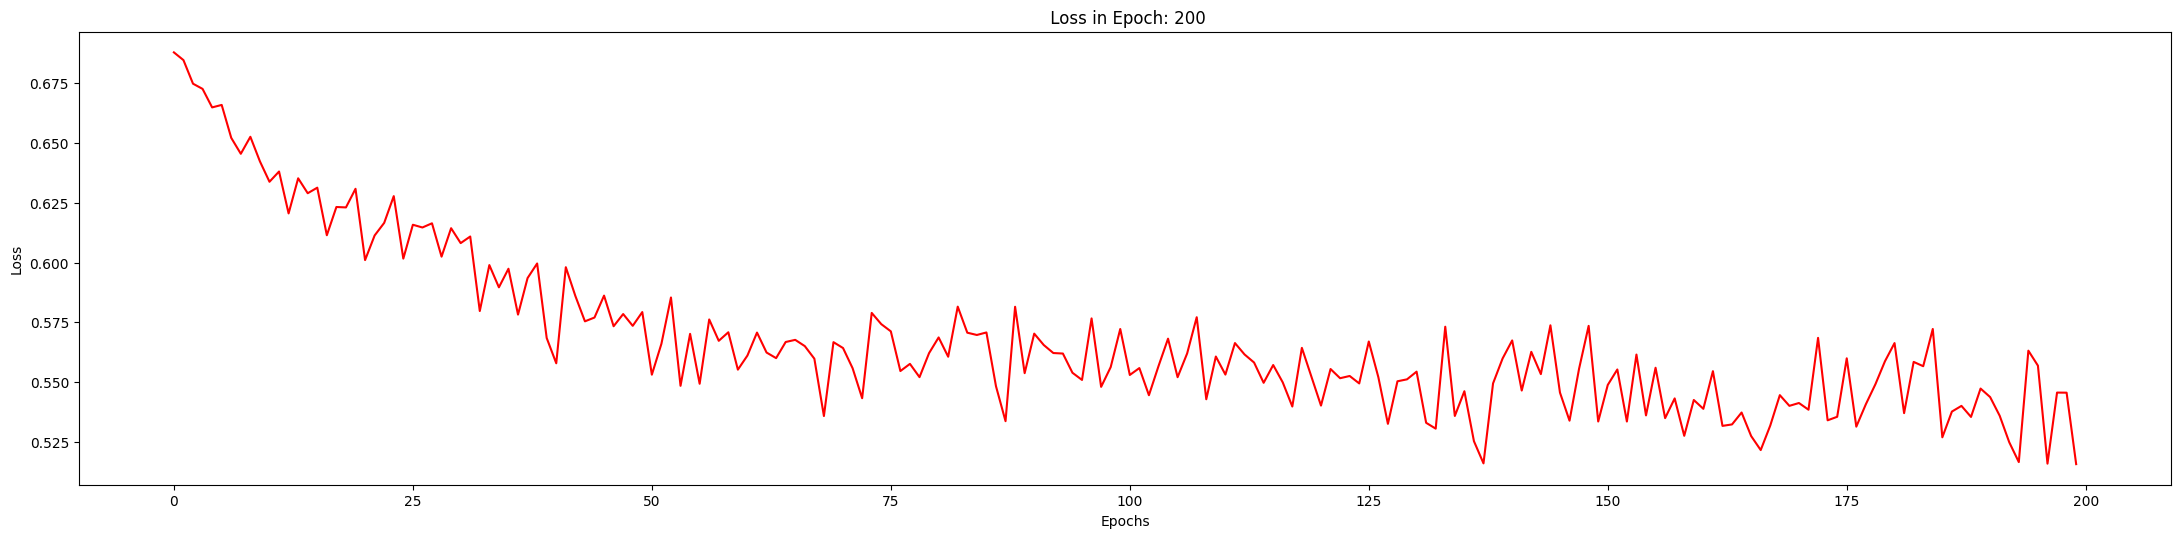

Epoch: 201, Model Loss: 0.5518
Epoch: 202, Model Loss: 0.5284
Epoch: 203, Model Loss: 0.5356
Epoch: 204, Model Loss: 0.5453
Epoch: 205, Model Loss: 0.5491
Epoch: 206, Model Loss: 0.5530
Epoch: 207, Model Loss: 0.5350
Epoch: 208, Model Loss: 0.5361
Epoch: 209, Model Loss: 0.5319
Epoch: 210, Model Loss: 0.5342
Epoch: 211, Model Loss: 0.5340
Epoch: 212, Model Loss: 0.5511
Epoch: 213, Model Loss: 0.5357
Epoch: 214, Model Loss: 0.5436
Epoch: 215, Model Loss: 0.5306
Epoch: 216, Model Loss: 0.5414
Epoch: 217, Model Loss: 0.5420
Epoch: 218, Model Loss: 0.5426
Epoch: 219, Model Loss: 0.5519
Epoch: 220, Model Loss: 0.5362
Epoch: 221, Model Loss: 0.5417
Epoch: 222, Model Loss: 0.5460
Epoch: 223, Model Loss: 0.5416
Epoch: 224, Model Loss: 0.5605
Epoch: 225, Model Loss: 0.5263
Epoch: 226, Model Loss: 0.5139
Epoch: 227, Model Loss: 0.5397
Epoch: 228, Model Loss: 0.5290
Epoch: 229, Model Loss: 0.5460
Epoch: 230, Model Loss: 0.5260
Epoch: 231, Model Loss: 0.5190
Epoch: 232, Model Loss: 0.5300
Epoch: 2

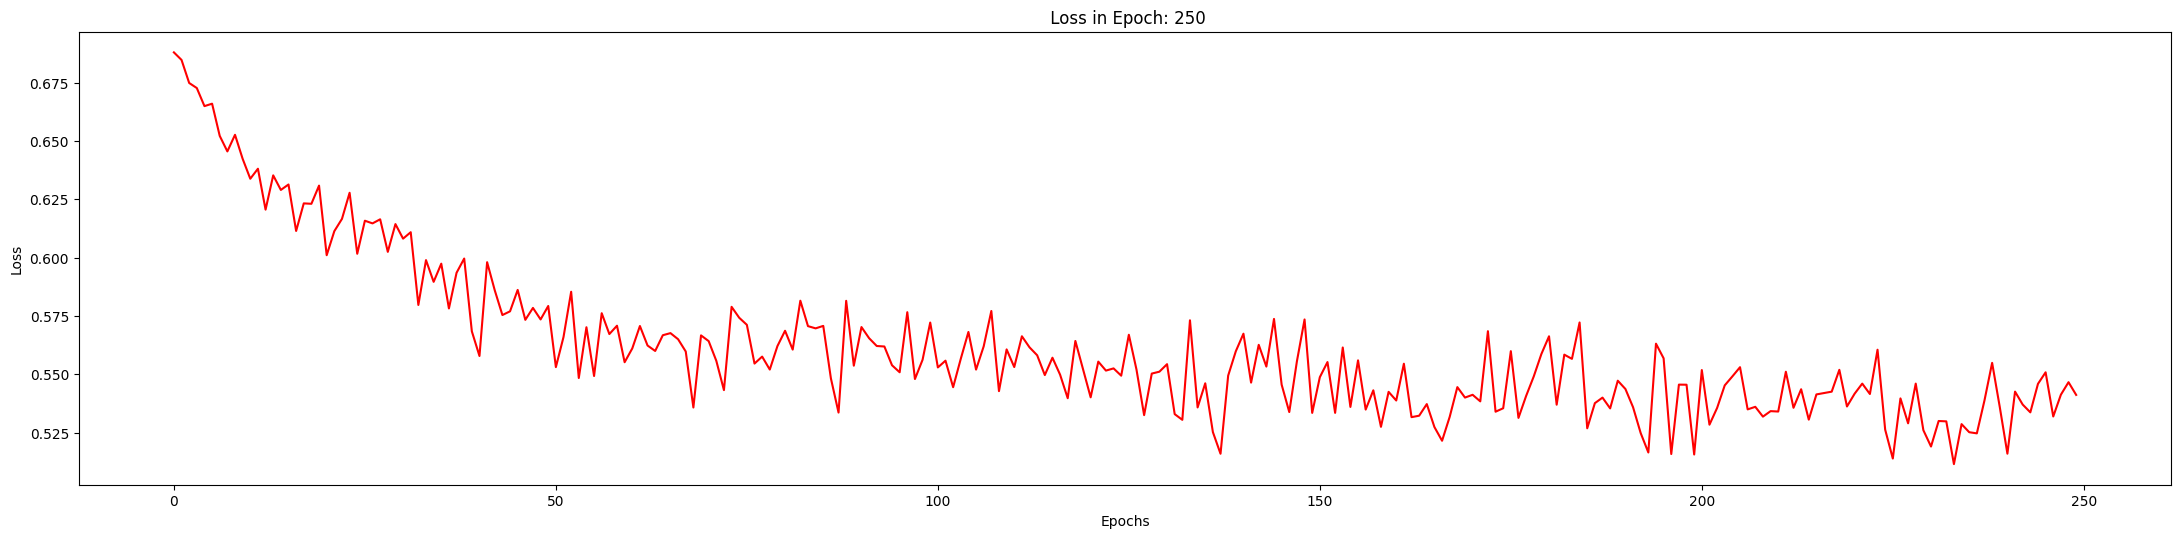

Epoch: 251, Model Loss: 0.5003
Epoch: 252, Model Loss: 0.5165
Epoch: 253, Model Loss: 0.5258
Epoch: 254, Model Loss: 0.5253
Epoch: 255, Model Loss: 0.5153
Epoch: 256, Model Loss: 0.5352
Epoch: 257, Model Loss: 0.5213
Epoch: 258, Model Loss: 0.5199
Epoch: 259, Model Loss: 0.5271
Epoch: 260, Model Loss: 0.5184
Epoch: 261, Model Loss: 0.5324
Epoch: 262, Model Loss: 0.5095
Epoch: 263, Model Loss: 0.5248
Epoch: 264, Model Loss: 0.5095
Epoch: 265, Model Loss: 0.5184
Epoch: 266, Model Loss: 0.5271
Epoch: 267, Model Loss: 0.5373
Epoch: 268, Model Loss: 0.5309
Epoch: 269, Model Loss: 0.5420
Epoch: 270, Model Loss: 0.5248
Epoch: 271, Model Loss: 0.5398
Epoch: 272, Model Loss: 0.5368
Epoch: 273, Model Loss: 0.5435
Epoch: 274, Model Loss: 0.5350
Epoch: 275, Model Loss: 0.5532
Epoch: 276, Model Loss: 0.5322
Epoch: 277, Model Loss: 0.5395
Epoch: 278, Model Loss: 0.5021
Epoch: 279, Model Loss: 0.5194
Epoch: 280, Model Loss: 0.5374
Epoch: 281, Model Loss: 0.5442
Epoch: 282, Model Loss: 0.5184
Epoch: 2

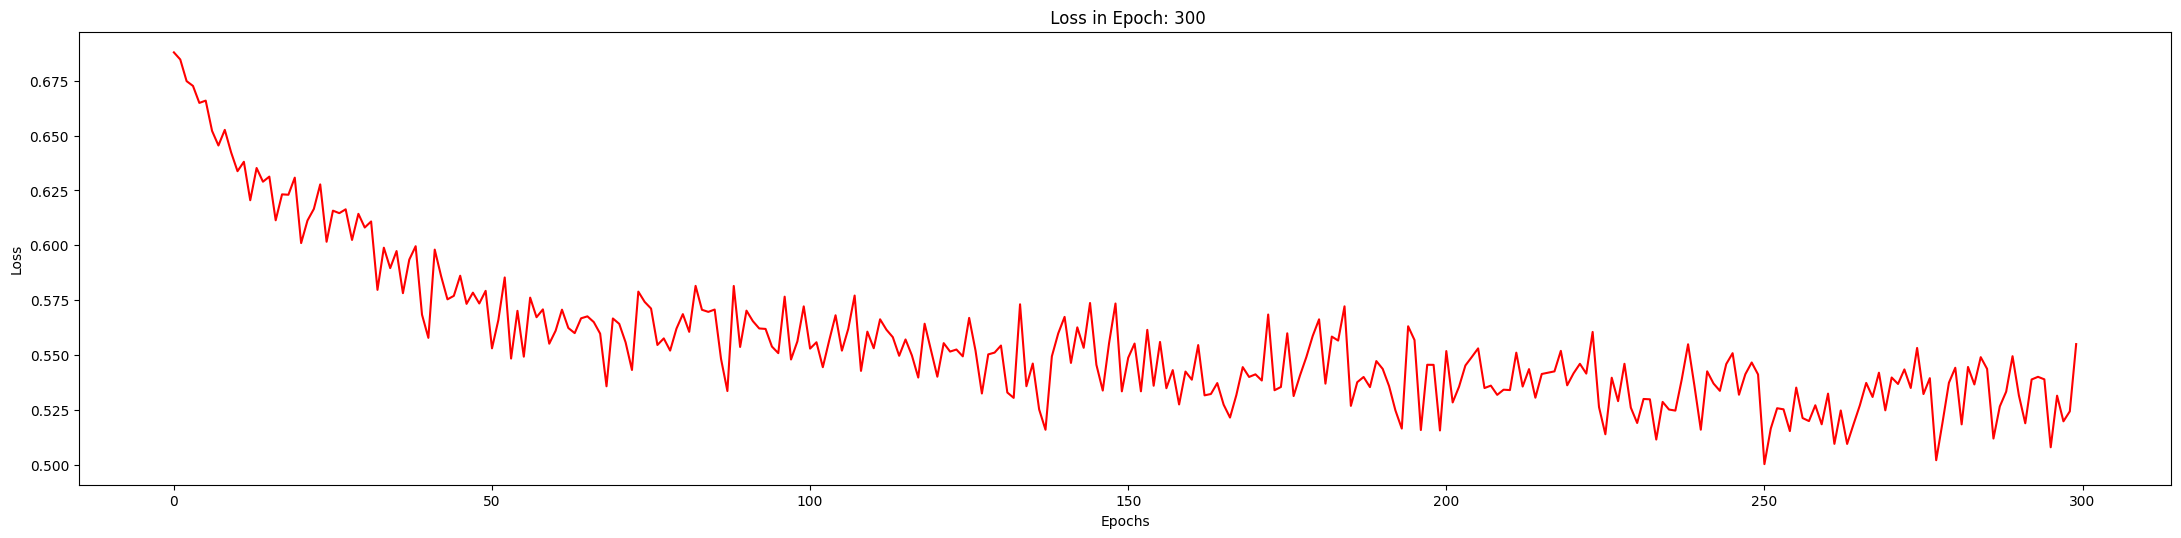

In [17]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index)

## **Test**

In [18]:
GNN_Model_test_predicted_labels = []

def GNN_Model_test(test_loader):
    GNN_Model.eval()
    correct = 0
    for batch_of_graphs in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        GNN_Model_test_pred = soft.argmax(dim=1).tolist()[0]
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #GNN_Model_test_pred = softmaxed_h2.argmax(dim=1)
        GNN_Model_test_predicted_labels.append(GNN_Model_test_pred)
        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())
    return correct / len(test_loader.dataset), GNN_Model_test_predicted_labels

In [19]:
GNN_Model_test_acc, predicted_labels = GNN_Model_test(test_dataloader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')


Test Accuracy: 0.6053


In [20]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [21]:
samples_time = instance_time(test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.002859107999995558, 0.001876015999982883, 0.0017367110000066077, 0.001776729999988902, 0.0018059800000003179, 0.0017574329999945348, 0.001693020000004708, 0.0017163859999982378, 0.001174300000002404, 0.0010799770000176068, 0.0011087510000038492, 0.0010753969999939272, 0.0011058279999929255, 0.001036986000002571, 0.0010422309999853496, 0.0010142049999899427, 0.0010168100000100821, 0.0010490809999907924, 0.0010601049999934276, 0.0010293720000049689, 0.0010098660000039672, 0.0010485819999814794, 0.0013263699999868095, 0.001076952000005349, 0.0010934409999947547, 0.0010305659999971795, 0.0010102360000132649, 0.0010116489999916212, 0.000996328000013591, 0.0013185230000090087, 0.0011201389999939693, 0.0010241090000135955, 0.0010140659999819945, 0.0010143469999945864, 0.0010236439999857794, 0.0010123120000002928, 0.0010290910000207987, 0.0010444769999935488]


In [22]:
real_labels = []
for graph in test_dataloader:
    real_labels.append(graph.y.tolist()[0])

In [23]:
print("predicted_labels: ", predicted_labels)
print("real_labels: ", real_labels)
print("Test Accuracy: ", metrics.accuracy_score(real_labels, predicted_labels))

predicted_labels:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
real_labels:  [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Test Accuracy:  0.6052631578947368


In [24]:
Auc_Roc = metrics.roc_auc_score(real_labels, predicted_labels)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predicted_labels)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predicted_labels, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predicted_labels, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5238095238095238 0.7918788907753254 0.6052631578947368 23


Check

In [25]:
print(GNN_Model)
test_dataloader_example = DataLoader(test_dataset, batch_size=1, shuffle=False)
for batch in test_dataloader_example:
    #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch)
    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch)
    break
#print(softmaxed_h2)
print(soft)
print(train_dataset[0].x)

GCN_plus_GAP(
  (GConvs): ModuleList(
    (0): GCNConv(7, 64)
    (1): GCNConv(64, 64)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=64, out_features=2, bias=True)
)
tensor([[0.0064, 0.9936]], grad_fn=<SoftmaxBackward0>)
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]

## **Explainer**

In [26]:
class Concept:
    def __init__(self, lamb, children=[], operator=''):
        self.lamb = lamb
        self.concept_set = None
        self.group = None
        self.children = children
        self.operator = operator

        assert operator in ['OR', 'AND'] and len(children) == 2 or operator == 'NOT' and len(children) == 1 \
               or operator == '' and children == []

        self.children.sort(key=lambda x: x.name())

    def __call__(self, graph, graph_idx=None):
        return self.lamb(graph)

    def __str__(self):
        return f'Conc({self.name()})'

    def __repr__(self):
        return self.__str__()

    def name(self):
        if self.operator == 'NOT':
            return f'(NOT {self.children[0].name()})'
        return f'({self.children[0].name()} {self.operator} {self.children[1].name()})'

    def length(self):
        if len(self.children) == 1:  # negation
            return self.children[0].length()
        return sum([c.length() for c in self.children])

    def flatten(self):
        ret = [self]
        for child in self.children:
            ret.extend(child.flatten())
        return ret

    def concept_groups(self):
        ret = set()
        if self.group is not None:
            ret.add(self.group)
        for concept in self.children:
            ret = ret.union(concept.concept_groups())
        return ret

    def union(self, concept):
        return Concept(lambda g: self.__call__(g).union(concept(g)),
                       children=[self, concept],
                       operator='OR')

    def inter(self, concept):
        return Concept(lambda g: self.__call__(g).inter(concept(g)),
                       children=[self, concept],
                       operator='AND')

    def inv(self):
        return Concept(lambda g: self.__call__(g).inv(),
                       children=[self],
                       operator='NOT')

In [27]:
class BasicConcepts:
    def degree(self, graph, k, operator='<'):
        """
        Nodes with degree in range.
        """
        adj_list = edge_index_to_adj_list(graph.edge_index)
        node_set = set()

        for node_idx in range(graph.x.shape[0]):
            if operator == '<' and len(adj_list[node_idx]) < k:
                node_set.add(node_idx)
            elif operator == '>' and len(adj_list[node_idx]) > k:
                node_set.add(node_idx)
            elif operator == '=' and len(adj_list[node_idx]) == k:
                node_set.add(node_idx)
        return ConceptMask(graph, set(), node_set)

    def feature(self, graph, j, k, operator='<'):
        node_set = set()
        for node_idx in range(graph.x.shape[0]):
            if operator == '<' and graph.x[node_idx, j] < k:
                node_set.add(node_idx)
            elif operator == '>' and graph.x[node_idx, j] > k:
                node_set.add(node_idx)
            elif operator == '=' and graph.x[node_idx, j] == k:
                node_set.add(node_idx)
        return ConceptMask(graph, set(), node_set)

    def neigh_degree(self, graph, k, operator='<', require=1, hops=1):
        """
        Nodes where neighbour satisfies degree condition.
        """
        adj_list = edge_index_to_adj_list(graph.edge_index, hops=hops, exclude_self=True)

        mask = []
        node_set = set()

        for node_idx in range(graph.x.shape[0]):
            ns = []
            for neigh in adj_list[node_idx]:
                if operator == '<' and len(adj_list[neigh]) < k or operator == '>' and len(adj_list[neigh]) > k \
                        or operator == '=' and len(adj_list[neigh]) == k:
                    ns.append(neigh)
            if len(ns) >= require:
                for neigh in ns:
                    mask.append((node_idx, neigh))
                    mask.append((neigh, node_idx))
                    node_set.add(node_idx)

        return ConceptMask(graph, set(), node_set)

    def neigh_feature(self, graph, j, k, operator='<', require=1, hops=1):
        adj_list = edge_index_to_adj_list(graph.edge_index, hops=hops, exclude_self=True)

        mask = []
        node_set = set()

        for node_idx in range(graph.x.shape[0]):
            ns = []
            for neigh in adj_list[node_idx]:
                if operator == '<' and graph.x[neigh, j] < k or operator == '>' and graph.x[neigh, j] > k \
                        or operator == '=' and graph.x[neigh, j] == k:
                    ns.append(neigh)
            if len(ns) >= require:
                for neigh in ns:
                    mask.append((node_idx, neigh))
                    mask.append((neigh, node_idx))
                    node_set.add(node_idx)

        return ConceptMask(graph, set(), node_set)


In [28]:
class MoleculeConcepts:
    def __init__(self, labels):
        self.labels = labels
        self.labels_inv = {pair[1]: pair[0] for pair in self.labels.items()}
        self.n_atoms = len(self.labels)

    def is_atom(self, x, atom):
        if atom == 'X':
            return True
        return not (x != torch.nn.functional.one_hot(torch.tensor(self.labels[atom]), self.n_atoms)).any()

    def element(self, x):
        return self.labels_inv[torch.argmax(x, dim=0).item()]

    def is_element(self, graph, ele):
        node_set = set()

        for node_idx in range(graph.x.shape[0]):
            if self.is_atom(graph.x[node_idx], ele):
                node_set.add(node_idx)

        return ConceptMask(graph, set(), node_set)

    def AB_K(self, graph, a, b, k):
        adj_list = edge_index_to_adj_list(graph.edge_index)
        mask = []

        assert a in self.labels.keys()
        assert b in self.labels.keys()

        for node_idx in range(graph.x.shape[0]):
            if self.is_atom(graph.x[node_idx], a):
                ox_edges = []
                for neigh in adj_list[node_idx]:
                    if self.is_atom(graph.x[neigh], b) and len(adj_list[neigh]) == 1:
                        ox_edges.append((node_idx, neigh))
                        ox_edges.append((neigh, node_idx))
                if len(ox_edges) == 2 * k:
                    mask.extend(ox_edges)

        return ConceptMask(graph, set(mask), set(np.unique([[pair[0], pair[1]] for pair in mask])))

    def element_neighbour(self, graph, ele_self, *eles_nb, strict=True, hops=1):
        """
        All instances of atom being only connected to elements specified.
        """
        assert all([ele in self.labels.keys() for ele in eles_nb])

        adj_list = edge_index_to_adj_list(graph.edge_index, hops=hops, exclude_self=True)
        mask = []
        node_set = set()

        def is_subseq(x, y):
            it = iter(y)
            return all(c in it for c in x)

        for node_idx in range(graph.x.shape[0]):
            if self.is_atom(graph.x[node_idx], ele_self):
                neighbs = []
                for neigh in adj_list[node_idx]:
                    neighbs.append(self.element(graph.x[neigh]))
                str_a = ''.join(sorted(neighbs))
                str_b = ''.join(sorted(eles_nb))
                if strict and str_a != str_b:
                    continue
                if not strict and not is_subseq(str_b, str_a):
                    continue
                for neigh in adj_list[node_idx]:
                    mask.append((node_idx, neigh))
                    mask.append((neigh, node_idx))
                node_set.add(node_idx)

        return ConceptMask(graph, set(mask), node_set)

    def element_same(self, graph, ele):
        """
        All edges connecting an element to the same element.
        """
        assert ele in self.labels.keys()

        edge_tuples = edge_index_to_tuples(graph.edge_index)
        mask = []

        carbon_indices = [node_idx for node_idx in range(graph.x.shape[0])
                          if self.is_atom(graph.x[node_idx], ele)]
        for idx in carbon_indices:
            for idx_ in carbon_indices:
                if idx != idx_ and (idx, idx_) in edge_tuples:
                    mask.append((idx, idx_))

        return ConceptMask(graph, set(mask), set(np.unique([[pair[0], pair[1]] for pair in mask])))

    def element_carbon(self, graph, ele):
        """
        All instances of atom being only connected to a carbon.
        """
        assert ele in self.labels.keys()

        adj_list = edge_index_to_adj_list(graph.edge_index)
        mask = []

        for node_idx in range(graph.x.shape[0]):
            if self.is_atom(graph.x[node_idx], ele) and len(adj_list[node_idx]) == 1:
                neigh = adj_list[node_idx][0]
                if self.is_atom(graph.x[neigh], 'C'):
                    mask.append((node_idx, neigh))
                    mask.append((neigh, node_idx))

        return ConceptMask(graph, set(mask), set(np.unique([[pair[0], pair[1]] for pair in mask])))


In [29]:
concepts_mutag = MoleculeConcepts({'C': 0, 'N': 1, 'O': 2, 'F': 3, 'I': 4, 'Cl': 5, 'Br': 6})

In [30]:
class BaseConcept(Concept):
    def __init__(self, name, lamb):
        super().__init__(lamb)
        self._name = name

    def name(self):
        return self._name

    def length(self):
        return 1

In [32]:
import copy
import numpy as np
import torch
import torch_scatter
from collections import defaultdict
from copy import deepcopy
from tqdm.notebook import tqdm

BEAM_WIDTH = 10


# a set of base concepts
class ConceptSet:
    def __init__(self, graphs, task, omega=[10, 20, 20]):
        self.num_graphs = len(graphs)
        self.graphs = graphs
        self.base_concepts = defaultdict(lambda: [None, defaultdict(lambda: None)])
        self.neuron_concept_tracker = {}  # maps neuron to list of lists [name, score, concept]
        self.cur_length = 1  # current formula length
        self.omega = omega

        print('Constructing base concepts')

        if task == 'MUTAG':
            concepts = [
                BaseConcept('isC ', lambda g: concepts_mutag.is_element(g, 'C')),
                BaseConcept('isN ', lambda g: concepts_mutag.is_element(g, 'N')),
                BaseConcept('isO ', lambda g: concepts_mutag.is_element(g, 'O')),
                BaseConcept('isF ', lambda g: concepts_mutag.is_element(g, 'F')),
                BaseConcept('isI ', lambda g: concepts_mutag.is_element(g, 'I')),
                BaseConcept('isCl', lambda g: concepts_mutag.is_element(g, 'Cl')),
                BaseConcept('isBr', lambda g: concepts_mutag.is_element(g, 'Br')),

                BaseConcept('nxC ', lambda g: concepts_mutag.element_neighbour(g, 'X', 'C', strict=False)),
                BaseConcept('nxN ', lambda g: concepts_mutag.element_neighbour(g, 'X', 'N', strict=False)),
                BaseConcept('nxF ', lambda g: concepts_mutag.element_neighbour(g, 'X', 'F', strict=False)),
                BaseConcept('nxO ', lambda g: concepts_mutag.element_neighbour(g, 'X', 'O', strict=False)),
                BaseConcept('nxCl', lambda g: concepts_mutag.element_neighbour(g, 'X', 'Cl', strict=False)),
                BaseConcept('nxBr', lambda g: concepts_mutag.element_neighbour(g, 'X', 'Br', strict=False)),
                BaseConcept('nxI ', lambda g: concepts_mutag.element_neighbour(g, 'X', 'I', strict=False)),

                [BaseConcept('nx1C', lambda g: concepts_mutag.element_neighbour(g, 'X', 'C', strict=True)),
                 BaseConcept('nx2C', lambda g: concepts_mutag.element_neighbour(g, 'X', 'C', 'C', strict=True)),
                 BaseConcept('nx3C', lambda g: concepts_mutag.element_neighbour(g, 'X', 'C', 'C', 'C', strict=True)
                             )],

                [BaseConcept(f'deg={i}', lambda g, i=i: concepts_basic.degree(g, k=i, operator='=')) for i in range(1, 4)],
                [BaseConcept(f'ndeg={i}', lambda g, i=i: concepts_basic.neigh_degree(g, k=i, operator='=', require=1)) for i in [1, 2, 3]]
            ]
        else:
            raise Exception('Unknown task %s' % task)

        for group_idx, group in enumerate(concepts):
            if isinstance(group, BaseConcept):
                group = [group]
            for concept in group:
                concept.group = group_idx
                self.base_concepts[concept.name()][0] = concept
                for graph_idx, graph in enumerate(graphs):
                    concept_mask = concept(graph)
                    self.base_concepts[concept.name()][1][graph_idx] = concept_mask
                self.compose(concept, concept, 'inv')

        self.clean_concepts()

        # for name, [obj, _] in self.base_concepts.items():
        #     print(f'{name}  {obj.concept_groups()}')

    def random_concept_set(self, n_concepts, max_length=3):
        cs = [v[0] for v in self.base_concepts.values()]
        ret = []
        for i in range(n_concepts):
            c = cs[np.random.randint(0, len(cs), 1)[0]]
            l = np.random.randint(0, max_length - 1, 1)[0]
            for _ in range(l):
                o = np.random.randint(0, 3, 1)[0]
                if o == 0:
                    c = self.compose(c, c, 'inv')[1]
                elif o == 1:
                    c_ = cs[np.random.randint(0, len(cs), 1)[0]]
                    c = self.compose(c, c_, 'union')[1]
                else:
                    c_ = cs[np.random.randint(0, len(cs), 1)[0]]
                    c = self.compose(c, c_, 'inter')[1]
            ret.append(c)
        return ret

    def free(self):
        for k, [_, dic] in self.base_concepts.items():
            dic.clear()

    # prune concepts which can be removed
    def clean_concepts(self):
        cleaned = 0
        marked_for_removal = []
        for concept_name, [_, dic] in self.base_concepts.items():
            if self.check_clean(concept_name):
                marked_for_removal.append(concept_name)
                cleaned += 1

        for concept_name in marked_for_removal:
            del self.base_concepts[concept_name]

        print(f'Pruned: {cleaned} concepts')
        print(f'Remaining: {len(self.base_concepts)} concepts')

    # check if a concept should be removed. remove concepts if they are not present
    # at all.
    def check_clean(self, concept_name):
        dic = self.base_concepts[concept_name][1]
        total_nodes = 0
        active_count = 0
        for _, graph_mask in dic.items():
            active_count += graph_mask.node_mask.sum()
            total_nodes += graph_mask.node_mask.shape[0]
        proportion = active_count / total_nodes
        return proportion == 0 or proportion == 1

    # get the mask of a specific concept for a graph
    def get_mask(self, concept, graph_idx):
        return self.base_concepts[concept.name()][1][graph_idx]

    # get the number of base concepts
    def num_concepts(self):
        return len(self.base_concepts)

    # logically compose two concepts using an operator. this will compose all of the
    # graph masks which are being tracked by this class.
    def compose(self, concept_a, concept_b, operator):
        if operator == 'union':
            concept_c = concept_a.union(concept_b)
        elif operator == 'inter':
            concept_c = concept_a.inter(concept_b)
        elif operator == 'inv':
            concept_c = concept_a.inv()
        else:
            raise Exception()

        if concept_c.name() in self.base_concepts:
            return [None, concept_c]

        self.base_concepts[concept_c.name()][0] = concept_c

        masks_a = self.base_concepts[concept_a.name()][1]
        masks_b = self.base_concepts[concept_b.name()][1]

        # for graph_idx in masks_a.keys():
        #     self.base_concepts[concept_c][graph_idx] = concept_c(self.graphs[graph_idx], graph_idx)

        for graph_idx in masks_a.keys():
            mask_a = masks_a[graph_idx]
            mask_b = masks_b[graph_idx]

            mask_c = None

            if operator == 'union':
                mask_c = mask_a.union(mask_b)
            elif operator == 'inter':
                mask_c = mask_a.inter(mask_b)
            elif operator == 'inv':
                mask_c = mask_a.inv()

            self.base_concepts[concept_c.name()][1][graph_idx] = mask_c

        return [None, concept_c]

    # expand to the next length of the beam search.
    def expand(self):
        marked_for_deletion = defaultdict(int)

        # only keep candidates within the beam by removing all others.
        if self.cur_length > 1:
            for neuron in self.neuron_concept_tracker.keys():
                tracked_concepts = [[v, c] for [v, c] in self.neuron_concept_tracker[neuron] if
                                    c.length() == self.cur_length]
                idxs1 = np.argsort([v[0] for [v, _] in tracked_concepts])

                for i in idxs1[-BEAM_WIDTH:]:
                    marked_for_deletion[tracked_concepts[i][1].name()] += 1

            deleted_set = set()
            for neuron in self.neuron_concept_tracker.keys():
                tracked_concepts = [[v, c] for [v, c] in self.neuron_concept_tracker[neuron] if
                                    c.length() == self.cur_length]
                for _, c in tracked_concepts:
                    c_name = c.name()
                    if c.length() == self.cur_length and marked_for_deletion[c_name] == 0 and c_name not in deleted_set:
                        self.base_concepts[c_name][1].clear()
                        deleted_set.add(c_name)

            print(f'Deleted: {len(deleted_set)}')

        pruned = 0

        # expand to the next depth
        for neuron in self.neuron_concept_tracker.keys():
            tracked_concepts = [[v, c] for [v, c] in self.neuron_concept_tracker[neuron] if
                                c.length() == self.cur_length]
            unary_concepts = [[v, c] for [v, c] in self.neuron_concept_tracker[neuron] if c.length() == 1]

            idxs1 = np.argsort([v[0] for [v, _] in tracked_concepts])[-BEAM_WIDTH:]
            idxs2 = np.argsort([v[0] for [v, _] in unary_concepts])

            for i in idxs1:
                for j in idxs2:
                    concept_a = tracked_concepts[i][1]
                    concept_b = unary_concepts[j][1]

                    common_groups = concept_a.concept_groups().intersection(concept_b.concept_groups())
                    if len(common_groups) > 0:
                        continue

                    if concept_a.length() + concept_b.length() != self.cur_length + 1:
                        continue

                    for op in ['inter', 'union']:
                        new_conc = self.compose(concept_a, concept_b, op)
                        if self.check_clean(new_conc[1].name()):
                            del self.base_concepts[new_conc[1].name()]
                            pruned += 1
                        else:
                            self.neuron_concept_tracker[neuron].append(new_conc)

        self.cur_length += 1

        print(f'Pruned: {pruned} concepts!')

    # Returns the concept indexes for neuron_idx which have not yet been scored.
    def get_unscored(self, neuron_idx):
        ret = []
        for idx, (score, _) in enumerate(self.neuron_concept_tracker[neuron_idx]):
            if score is None:
                ret.append(idx)
        return ret

    def truth(self, neuron_idx, concept_idxs):
        """
        :param neuron_idx: neuron index
        :return: matrix of shape #concepts x #nodes (across all graphs)
        """
        mat = []
        for concept_idx in concept_idxs:
            [_, concept] = self.neuron_concept_tracker[neuron_idx][concept_idx]
            row = []
            for graph_idx, concept_mask in self.base_concepts[concept.name()][1].items():
                row.append(concept_mask.node_mask)
            mat.append(torch.cat(row).unsqueeze(0))
        return torch.cat(mat)

    def match(self, neuron_activations, norm, inds):
        """
        Updates score for each concept for all neurons.
        :param neuron_activations:  #neurons x #nodes, all graphs stacked, normalised
        :param norm: #nodes x 1, normalisation term
        """

        n_nodes = neuron_activations.shape[1]

        device = torch.device('cuda:0')
        neuron_activations = neuron_activations.to(device)
        inds = inds.to(device)

        for neuron_idx in range(neuron_activations.shape[0]):
            if neuron_idx not in self.neuron_concept_tracker:
                self.neuron_concept_tracker[neuron_idx] = []
                for _, [concept, _] in self.base_concepts.items():
                    self.neuron_concept_tracker[neuron_idx].append([None, concept])

            unscored_concepts = self.get_unscored(neuron_idx)
            n_concepts = len(unscored_concepts)

            if n_concepts == 0:
                continue

            targets = self.truth(neuron_idx, unscored_concepts)
            activations = neuron_activations[neuron_idx, :]  # 1D, all activations for neuron

            n_graphs_with_acts = torch_scatter.scatter_add(activations, inds).nonzero().shape[0]
            max_act = torch_scatter.scatter_max(activations, inds)[0].sum()
            if n_graphs_with_acts > 0:
                max_act /= n_graphs_with_acts

            activations = activations.repeat(n_concepts, 1)

            assert activations.shape[0] == n_concepts and activations.shape[1] == n_nodes
            assert targets.shape[0] == n_concepts and targets.shape[1] == n_nodes

            err = torch.zeros(n_concepts).to(device)
            targets = targets.to(device)

            [alpha, beta, gamma] = self.omega

            final_thresholds = torch.zeros(activations.shape[0], device=device)

            for thresh in np.arange(alpha, beta) / gamma * max_act.item():
                acts = activations > thresh

                msk = torch.zeros(activations.shape, device=device)
                nonzids = acts.nonzero().T
                if nonzids.shape[0] > 0:
                    msk[nonzids[0], nonzids[1]] = 1
                act_th = activations * msk

                inters = torch_scatter.scatter_add(torch.logical_and(acts, targets).float(), inds)
                unions = torch_scatter.scatter_add(torch.logical_or(acts, targets).float(), inds)

                framed = torch_scatter.scatter_add(torch.logical_and(acts, targets).float() * act_th, inds)
                signal = torch_scatter.scatter_add(act_th, inds)

                frac = torch.nan_to_num((inters / unions) * (framed / signal), 0, 0, 0)

                denom = torch.logical_or(inters != 0, unions != 0).sum(dim=1)
                e_ = frac.sum(dim=1) / denom
                final_thresholds[torch.where(e_ > err)] = thresh
                err = torch.maximum(err, e_)

            assert err.shape[0] == n_concepts and len(err.shape) == 1

            for i, concept_idx in enumerate(unscored_concepts):
                self.neuron_concept_tracker[neuron_idx][concept_idx][0] = (err[i].item(), final_thresholds[i].item())

            del targets

        del neuron_activations

        ret_dic = {}
        for neuron_idx in self.neuron_concept_tracker.keys():
            ret_dic[neuron_idx] = {}
            for [val, concept] in self.neuron_concept_tracker[neuron_idx]:
                ret_dic[neuron_idx][concept.name()] = (concept, val[0], val[1])
        return ret_dic

    def similarity(self, neuron_activations):
        """
        Computes concept similarity between all neurons and all concepts.
        :param neuron_activations: feature maps, shape should be #nodes x #neurons
        :return: #neurons x #concepts matrix of concept scores.
        """
        neuron_activations = neuron_activations.T
        n_neurons = neuron_activations.shape[0]

        n_a = neuron_activations.repeat_interleave(len(self.concepts), 0)
        mask = self.node_mask.repeat(n_neurons, 1)

        row_mins = n_a.min(dim=1)[0]
        row_maxs = n_a.max(dim=1)[0]
        denom = row_maxs - row_mins
        zero_rows = (n_a.abs().sum(axis=1).bool() == 0).nonzero().squeeze(1)

        denom = denom.index_fill(dim=0, index=zero_rows, value=1.0)
        normed = (n_a - row_mins[:, None]) / denom[:, None]

        err = torch.nn.MSELoss(reduction='none')(normed, mask)
        err = 1 - err.mean(axis=1)  # (1, n_nodes x n_concepts)

        return err.reshape(n_neurons, len(self.concepts))

    def self_expand(self):
        ors = []
        ands = []
        nots = []

        n_concepts = len(self.concepts)

        for i in range(n_concepts):
            for j in range(i, n_concepts):
                ors.append(self.concepts[i].union(self.concepts[j]))
                ands.append(self.concepts[i].inter(self.concepts[j]))
                nots.append(self.concepts[i].inv())

        self.concepts.extend(ors)
        self.concepts.extend(ands)
        self.concepts.extend(nots)

        return ConceptSet(*copy.deepcopy(self.concepts))

In [33]:
from torch.autograd import graph
from typing import Any, Dict, Optional, Union


class my_explainer_handler:
    def __init__(self, model):
        self.model = model
        self.task = "MUTAG"

    def __call__(self, dataset, depth=1, neuron_idxs=[], top=64, augment=True, omega=[10, 20, 20], level=1):
        self.concept_search(self.task, dataset, depth=1, neuron_idxs=[], top=64, augment=True, omega=[10, 20, 20], level=1)

    def concept_search(self, task, dataset, depth=1, neuron_idxs=[], top=64, augment=True, omega=[10, 20, 20], level=1):
        assert depth >= 1

        if augment:
            print('Graph augmentation')
            dataset_aug = []
            for graph in tqdm(dataset):
                edge_tuples = edge_index_to_tuples(graph.edge_index)
                dataset_aug.append(copy.deepcopy(graph))
                for _ in range(4):
                    graph_new = copy.deepcopy(graph)
                    for _ in range(8):
                        source_node = np.random.randint(0, graph_new.x.shape[0])
                        target_node = np.random.randint(0, graph_new.x.shape[0])
                        add_edge(graph_new, source_node, target_node)
                    dataset_aug.append(graph_new)
            dataset = dataset_aug

        num_graphs = len(dataset)
        concept_set = ConceptSet(dataset, task, omega=omega)

        print('Performing inference')
        neuron_activations = []
        graph_sizes = []
        graph_inds = []

        for i in tqdm(range(num_graphs)):
            graph = dataset[i]
            feature_maps = self.partial_forward(graph.x.to(self.device), graph.edge_index.to(self.device),
                                                ret_layer=self.n_layers - level).detach().cpu().T
            neuron_activations.append(feature_maps)

            graph_sizes.extend([graph.x.shape[0]] * graph.x.shape[0])
            graph_inds.extend([i] * graph.x.shape[0])

        print('Keeping only top neurons')
        neuron_activations = torch.cat(neuron_activations, 1)
        nrns_vals = (neuron_activations != 0).sum(axis=1)
        neuron_idxs = nrns_vals.argsort()
        non_zero_neuron_idxs = []
        for idx in neuron_idxs:
            if nrns_vals[idx] == 0:
                continue
            non_zero_neuron_idxs.append(idx)
        non_zero_neuron_idxs = torch.LongTensor(non_zero_neuron_idxs)
        neuron_idxs = non_zero_neuron_idxs
        neuron_activations = neuron_activations.index_select(0, neuron_idxs[-top:])

        print('Performing search')

        for i in range(depth):
            ret = concept_set.match(neuron_activations, torch.tensor(graph_sizes), torch.tensor(graph_inds))

            if i < depth - 1:
                print('Adding concepts')
                concept_set.expand()
                print('Number of concepts: ' + str(concept_set.num_concepts()))

        concept_set.free()

        return_dic = {}
        for k, v in ret.items():
            return_dic[neuron_idxs[k].item()] = v

        return return_dic

## **GlobalConceptBased**

In [38]:
from collections import defaultdict
def def_value():
    return "Not Present"

# Defining the dict
d = defaultdict(list)
d["a"] = 1
d["b"] = 2

print(d["a"])
print(d["b"])
print(d["c"])

1
2
[]


In [39]:
print(dataset[0].x.shape)
node_i = np.random.randint(0, dataset[0].x.shape[0])

torch.Size([17, 7])


In [ ]:
def edge_index_to_tuples(edge_index):
    return [(pair[0].item(), pair[1].item()) for pair in edge_index.T]


def add_edge(g, u, v):
    if (u, v) in edge_index_to_tuples(g.edge_index):
        return
    g.edge_index = torch.column_stack([g.edge_index, torch.tensor([[u, v], [v, u]])])


def partial_forward(self, x, edge_index, ret_layer=None):
    if ret_layer is None:
        ret_layer = self.n_layers - 1

    for idx, conv in enumerate(self.convs):
        x = conv(x, edge_index)

        x = F.relu(x)

        if len(self.erasures[idx]) != 0:
            rem = torch.tensor(self.erasures[idx])
            x = torch.where(F.one_hot(rem, x.shape[1]).sum(axis=0) == 1, torch.tensor(0.), x)

        if idx == ret_layer:
            break

    if self.bottleneck_concepts != []:
        x = x.index_select(1, torch.LongTensor(self.bottleneck_concepts).to(self.device))

    return x


def concept_search(self, task, dataset, depth=1, neuron_idxs=[], top=64, augment=True, omega=[10, 20, 20], level=1):
    assert depth >= 1

    if augment:
        print('Graph augmentation')
        dataset_aug = []
        for graph in tqdm(dataset):
            edge_tuples = edge_index_to_tuples(graph.edge_index)
            dataset_aug.append(copy.deepcopy(graph))
            for _ in range(4):
                graph_new = copy.deepcopy(graph)
                for _ in range(8):
                    source_node = np.random.randint(0, graph_new.x.shape[0])
                    target_node = np.random.randint(0, graph_new.x.shape[0])
                    add_edge(graph_new, source_node, target_node)
                dataset_aug.append(graph_new)
        dataset = dataset_aug

    num_graphs = len(dataset)
    concept_set = ConceptSet(dataset, task, omega=omega)

    print('Performing inference')
    neuron_activations = []
    graph_sizes = []
    graph_inds = []

    for i in tqdm(range(num_graphs)):
        graph = dataset[i]
        feature_maps = self.partial_forward(graph.x.to(self.device), graph.edge_index.to(self.device),
                                            ret_layer=self.n_layers - level).detach().cpu().T
        neuron_activations.append(feature_maps)

        graph_sizes.extend([graph.x.shape[0]] * graph.x.shape[0])
        graph_inds.extend([i] * graph.x.shape[0])

    print('Keeping only top neurons')
    neuron_activations = torch.cat(neuron_activations, 1)
    nrns_vals = (neuron_activations != 0).sum(axis=1)
    neuron_idxs = nrns_vals.argsort()
    non_zero_neuron_idxs = []
    for idx in neuron_idxs:
        if nrns_vals[idx] == 0:
            continue
        non_zero_neuron_idxs.append(idx)
    non_zero_neuron_idxs = torch.LongTensor(non_zero_neuron_idxs)
    neuron_idxs = non_zero_neuron_idxs
    neuron_activations = neuron_activations.index_select(0, neuron_idxs[-top:])

    print('Performing search')

    for i in range(depth):
        ret = concept_set.match(neuron_activations, torch.tensor(graph_sizes), torch.tensor(graph_inds))

        if i < depth - 1:
            print('Adding concepts')
            concept_set.expand()
            print('Number of concepts: ' + str(concept_set.num_concepts()))

    concept_set.free()

    return_dic = {}
    for k, v in ret.items():
        return_dic[neuron_idxs[k].item()] = v

    return return_dic